<a href="https://colab.research.google.com/github/kalvin-osoro/AI-ML-Group-Task/blob/main/sift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install gdown
!gdown --id 1IQ90jtnITrrcBWsFjF8jkFXF7LAxDqLF

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1IQ90jtnITrrcBWsFjF8jkFXF7LAxDqLF 



In [ ]:
%%time
import zipfile
zip_ref = zipfile.ZipFile("archive.zip", 'r')
zip_ref.extractall("./scenery")
zip_ref.close()

CPU times: user 3.5 s, sys: 1.23 s, total: 4.73 s
Wall time: 5.43 s


In [3]:
import matplotlib.pyplot as plt
def show_images(images, figsize=(20,10), columns = 5):
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(image)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
IMAGE_PATH="/content/drive/MyDrive/lions"
file_names=os.listdir(IMAGE_PATH)
print(f"number of images: {len(file_names)}")

number of images: 7


In [8]:
import cv2
import numpy as np
from PIL import Image
from os import listdir
import pickle as pk
import math
from tqdm import tqdm
sift = cv2.SIFT_create(nfeatures=500)

def resize_img_to_array(img):
    height,width=img.size
    if height*width>2000*2000:
        k=math.sqrt(height*width/(2000*2000))
        img=img.resize(
            (round(height/k),round(width/k)), 
            Image.ANTIALIAS
        )
    img_array = np.array(img)
    return img_array

def calculate_descr(img):
    eps=1e-7
    img=resize_img_to_array(img)
    key_points, descriptors = sift.detectAndCompute(img, None)
    if descriptors is None:
      return (None,None)
    descriptors /= (descriptors.sum(axis=1, keepdims=True) + eps) #RootSift
    descriptors = np.sqrt(descriptors)    #RootSift
    return (key_points,descriptors)

IMAGES_PATH="/content/drive/MyDrive/lions"
file_names=listdir(IMAGES_PATH)
all_image_features=[]
for file_name in tqdm(file_names):
    img = Image.open(IMAGES_PATH+"/"+file_name)
    keyp,descs=calculate_descr(img)
    if descs is None:
        continue
    if descs.shape[0]==1:
        continue
    all_image_features.append({"descs":descs,"file_name":file_name})
pk.dump(all_image_features, open("all_image_features.pkl","wb"))

100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


(500, 128)


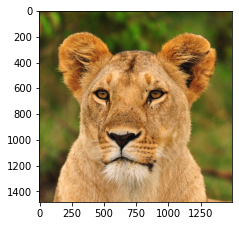

In [15]:
import numpy as np
from PIL import Image
query_image_pillow=Image.open(f'{IMAGES_PATH}/LE.jpg')
query_image_features=calculate_descr(query_image_pillow)[1]
show_images([np.array(query_image_pillow)])
print(query_image_features.shape)

In [16]:
bf = cv2.BFMatcher()
def match_descriptors(IMAGE_SIMILARITIES,filename,matches):
    good_matches = []
    good_matches_sum=0
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_matches.append(m)
            good_matches_sum+=m.distance
    if len(good_matches)<5:
        return
    bestN=5
    topBestNSum=0
    good_matches.sort(key=lambda match: match.distance)
    for match in good_matches[:bestN]:
        topBestNSum+=match.distance
    IMAGE_SIMILARITIES.append({"id": filename, "distance": (topBestNSum/bestN)*good_matches_sum/(len(good_matches))})

def sift_reverse_search(image_file):
    IMAGE_SIMILARITIES=[]
    _,target_descriptors=calculate_descr(image_file)
    for image in all_image_features:
        matches = bf.knnMatch(target_descriptors,image["descs"], k=2)
        match_descriptors(IMAGE_SIMILARITIES,image["file_name"],matches)
    IMAGE_SIMILARITIES.sort(key=lambda image: image["distance"])
    print(IMAGE_SIMILARITIES[:10])
    return list(map(lambda el: el["id"],IMAGE_SIMILARITIES[:10]))

In [17]:
%%time
res=sift_reverse_search(query_image_pillow)
print(res)

[{'id': 'LE.jpg', 'distance': 0.0}, {'id': 'Profile.jpg', 'distance': 0.0}, {'id': 'PROF.jpg', 'distance': 0.12307732314988473}, {'id': 'PROF1.jpg', 'distance': 0.13107728264013319}]
['LE.jpg', 'Profile.jpg', 'PROF.jpg', 'PROF1.jpg']
CPU times: user 996 ms, sys: 27.5 ms, total: 1.02 s
Wall time: 771 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


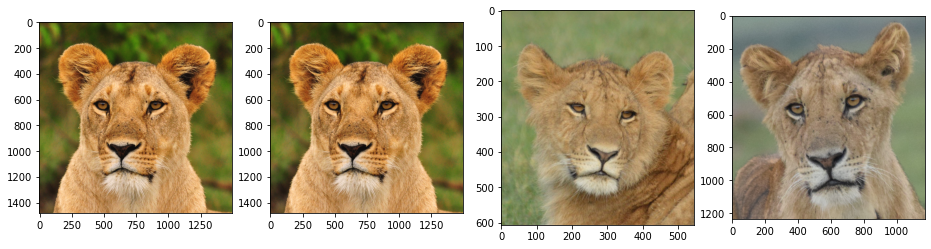

In [18]:
found_images=[]
for file_name in res:
    found_images.append(np.array(Image.open(IMAGES_PATH+"/"+file_name)))
show_images(np.array(found_images))

[{'id': 'LE.jpg', 'distance': 0.0}, {'id': 'Profile.jpg', 'distance': 0.0}]


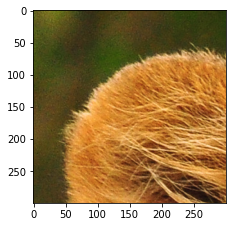

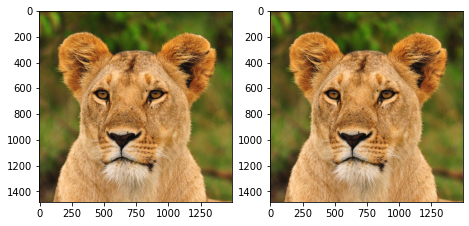

In [19]:
crop_rectangle = (100, 100, 400, 400)
query_image_cropped = query_image_pillow.crop(crop_rectangle)
res2=sift_reverse_search(query_image_cropped)
show_images([np.array(query_image_cropped)])
found_images_2=[]
for file_name in res2:
    found_images_2.append(np.array(Image.open(IMAGES_PATH+"/"+file_name)))
show_images(np.array(found_images_2))